# 1. Import Thư viện

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')


# 2. Tải Dữ liệu đã Xử lý

In [2]:
PROCESSED_PATH = '../data/processed'

print(f"Đang tải dữ liệu từ thư mục: {PROCESSED_PATH}")

try:
    user_indices = np.load(os.path.join(PROCESSED_PATH, 'user_indices.npy'))
    product_indices = np.load(os.path.join(PROCESSED_PATH, 'product_indices.npy'))
    ratings = np.load(os.path.join(PROCESSED_PATH, 'ratings.npy'))
    user_ids_map = np.load(os.path.join(PROCESSED_PATH, 'user_ids_map.npy'))
    product_ids_map = np.load(os.path.join(PROCESSED_PATH, 'product_ids_map.npy'))
    
    n_users = len(user_ids_map)
    n_items = len(product_ids_map)

    print("Tải dữ liệu thành công!")
    print(f"Số lượng user: {n_users}")
    print(f"Số lượng item: {n_items}")
    print(f"Số lượng rating: {len(ratings)}")

except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp dữ liệu đã xử lý.")
    print("Vui lòng chạy notebook '02_preprocessing.ipynb' trước.")


Đang tải dữ liệu từ thư mục: ../data/processed
Tải dữ liệu thành công!
Số lượng user: 5249
Số lượng item: 53970
Số lượng rating: 138204


# 3. Phân chia Dữ liệu (Train-Test Split)

Chia tập `ratings` thành 80% cho việc huấn luyện và 20% cho việc kiểm thử:
1. Tạo một mảng chỉ số.
2. Xáo trộn ngẫu nhiên mảng này.
3. Phân chia các chỉ số đã xáo trộn thành hai tập train và test.

In [3]:
# 1. Tạo và xáo trộn các chỉ số
np.random.seed(42) # Để đảm bảo kết quả có thể tái lập
shuffled_indices = np.random.permutation(len(ratings))

# 2. Xác định điểm chia
test_size = 0.2
split_point = int(len(ratings) * (1 - test_size))

# 3. Phân chia chỉ số
train_indices = shuffled_indices[:split_point]
test_indices = shuffled_indices[split_point:]

# 4. Tạo các tập train và test từ các chỉ số
X_train_users = user_indices[train_indices]
X_train_items = product_indices[train_indices]
y_train = ratings[train_indices]

X_test_users = user_indices[test_indices]
X_test_items = product_indices[test_indices]
y_test = ratings[test_indices]

print(f"Số lượng mẫu trong tập train: {len(y_train)}")
print(f"Số lượng mẫu trong tập test: {len(y_test)}")


Số lượng mẫu trong tập train: 110563
Số lượng mẫu trong tập test: 27641


# 4. Xây dựng Ma trận User-Item

Ma trận User-Item là thành phần cốt lõi, với mỗi hàng đại diện cho một người dùng, mỗi cột đại diện cho một sản phẩm, và giá trị tại ô `(u, i)` là rating của user `u` cho item `i`.

In [4]:
# Tạo ma trận User-Item từ tập train
# Giá trị 0 có nghĩa là user chưa rate item đó
train_user_item_matrix = np.zeros((n_users, n_items))
for i in range(len(X_train_users)):
    user_id = X_train_users[i]
    item_id = X_train_items[i]
    rating = y_train[i]
    train_user_item_matrix[user_id, item_id] = rating

print("Kích thước ma trận User-Item (train):", train_user_item_matrix.shape)
print("Một phần của ma trận:")
print(train_user_item_matrix[:5, :10])


Kích thước ma trận User-Item (train): (5249, 53970)
Một phần của ma trận:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 5.0. Xây dựng Mô hình

- Bối cảnh dữ liệu: ma trận tương tác user–item rất thưa; số lượng item lớn → xây dựng ma trận tương đồng item–item kích thước n_items × n_items dễ vượt quá RAM.

- Baseline đề xuất: User-based CF (UCF)

  - Lý do: UCF dùng ma trận tương đồng user–user (n_users × n_users), vì n_users nhỏ hơn rất nhiều so với n_items nên tiết kiệm bộ nhớ hơn so với item-based CF trong bài toán này.
  - Ưu điểm: đơn giản, trực quan, ít phụ thuộc vào đặc trưng thủ công; phù hợp làm baseline tham chiếu.
  - Lưu ý: Khi dữ liệu cực thưa, UCF có thể kém ổn định; có thể giới hạn top-k neighbors và/hoặc tính theo nhu cầu (on-demand) để giảm chi phí.

- Mô hình Phân rã Ma trận (Matrix Factorization)

  - MF-SGD: học latent factors cho user/item cùng với bias (μ, b_u, b_i); cập nhật bằng tối ưu gradient; có thể clip dự đoán về [1, 5].
  - ALS (Vectorized): cập nhật toàn cục P và Q thông qua công thức đóng, thường hội tụ nhanh và ổn định; phù hợp dữ liệu thưa và không cần đặc trưng thủ công.

- Latent-feature learning thay cho feature engineering truyền thống

  - Thay vì xây dựng đặc trưng thủ công cho user/item, MF tự học biểu diễn ẩn từ dữ liệu tương tác, phù hợp khi metadata hạn chế.
  - Có thể mở rộng sang mô hình lai (hybrid) nếu sau này có thêm đặc trưng nội dung/nhân khẩu học.


## 5.1. Mô hình 1: Lọc cộng tác Người-Người (User-based CF)

Mô hình này hoạt động bằng cách tìm những người dùng có cùng sở thích và dựa vào rating của họ để đưa ra dự đoán.

### Xây dựng Hàm dự đoán (User-Based)

Để dự đoán rating của user `u` cho item `i`, chúng ta sẽ:
1.  Tìm `k` người dùng tương đồng nhất với `u` mà đã rate item `i`.
2.  Lấy trung bình có trọng số các rating của những người dùng này cho item `i`. Trọng số chính là độ tương đồng của họ với `u`.

Công thức:
$$ \hat{r}_{u,i} = \frac{\sum_{v \in N_k(u,i)} \text{sim}(u,v) \cdot r_{v,i}}{\sum_{v \in N_k(u,i)} |\text{sim}(u,v)|} $$
Trong đó:
- $\hat{r}_{u,i}$ là rating dự đoán.
- $N_k(u,i)$ là tập `k` user tương đồng nhất với `u` đã rate item `i`.
- $\text{sim}(u,v)$ là độ tương đồng giữa user `u` và `v`.
- $r_{v,i}$ là rating thực tế của user `v` cho item `i`.

In [5]:
class UserBasedCF:
    def __init__(self, n_users, k=20, dtype=np.float32):
        self.n_users = n_users
        self.k = k
        self.dtype = dtype
        self.similarity_matrix = None

    def fit(self, rating_matrix):
        """
        Tính ma trận tương đồng User-User bằng Cosine Similarity (NumPy thuần).
        """
        UI = rating_matrix.astype(self.dtype, copy=False)
        dot_product = UI @ UI.T
        norms = np.linalg.norm(UI, axis=1).astype(self.dtype, copy=False)
        norm_matrix = np.outer(norms, norms)
        norm_matrix[norm_matrix == 0] = 1e-8
        self.similarity_matrix = dot_product / norm_matrix
        np.fill_diagonal(self.similarity_matrix, 0)
        return self

    def predict_full(self, rating_matrix):
        """
        Dự đoán toàn bộ ma trận rating theo công thức trọng số:
        Pred = (Sim @ Ratings) / (|Sim| @ Mask), với Mask = 1 nếu đã rate, ngược lại 0.
        """
        if self.similarity_matrix is None:
            raise ValueError("Chưa fit: hãy gọi fit(rating_matrix) trước khi dự đoán.")
        UI = rating_matrix.astype(self.dtype, copy=False)
        numerator = self.similarity_matrix @ UI
        mask = (UI > 0).astype(self.dtype, copy=False)
        denominator = np.abs(self.similarity_matrix) @ mask
        denominator[denominator == 0] = 1e-8
        return numerator / denominator

    def predict_pairs(self, test_users, test_items, rating_matrix):
        """
        Dự đoán cho danh sách cặp (user, item) bằng phương pháp top-k hàng xóm.
        Tránh tạo ma trận dự đoán toàn phần để tiết kiệm bộ nhớ.
        """
        if self.similarity_matrix is None:
            raise ValueError("Chưa fit: hãy gọi fit(rating_matrix) trước khi dự đoán.")
        UI = rating_matrix.astype(self.dtype, copy=False)
        sim_rows = self.similarity_matrix[test_users].astype(self.dtype, copy=False)  # (N, U)
        item_cols = UI[:, test_items]                                                 # (U, N)
        raters_mask = item_cols > 0                                                   # (U, N)

        sim_with_raters = np.where(raters_mask, sim_rows.T, 0.0)                      # (U, N)
        ratings_from_raters = np.where(raters_mask, item_cols, 0.0)                   # (U, N)

        k = min(self.k, sim_with_raters.shape[0])
        topk_idx = np.argpartition(sim_with_raters, -k, axis=0)[-k:]                  # (k, N)
        cols = np.arange(sim_with_raters.shape[1])[None, :].repeat(k, axis=0)
        topk_sims = sim_with_raters[topk_idx, cols]                                   # (k, N)
        topk_rates = ratings_from_raters[topk_idx, cols]                              # (k, N)

        numerator = np.einsum('kn,kn->n', topk_sims, topk_rates).astype(np.float64)   # (N,)
        denom = np.einsum('kn->n', np.abs(topk_sims)).astype(np.float64)              # (N,)

        preds = np.empty_like(numerator, dtype=float)
        zero_den = denom == 0
        preds[~zero_den] = numerator[~zero_den] / denom[~zero_den]

        if np.any(zero_den):
            zcols = np.where(zero_den)[0]
            col_vals = UI[:, test_items[zcols]].astype(np.float64, copy=False)        # (U, M)
            nonzero_mask = col_vals > 0
            sums = np.einsum('um->m', np.where(nonzero_mask, col_vals, 0.0))
            counts = np.einsum('um->m', nonzero_mask)
            means = np.divide(sums, counts, out=np.full_like(sums, 3.0), where=counts>0)
            preds[zero_den] = means

        return preds


## 5.2. Mô hình 2: Phân rã Ma trận (Matrix Factorization - SGD)

Ý tưởng: xấp xỉ ma trận rating R (Users × Items) bằng tích của hai ma trận hạng thấp `P` (Users × K) và `Q` (Items × K).
Ta học tham số bằng SGD chỉ trên các ô có rating (tránh tác động từ ô 0).

- Hàm mất mát: $\sum_{(u,i) \in \Omega} (r_{u,i} - (\mu + b_u + b_i + P_u \cdot Q_i))^2 + \lambda (\|P\|^2 + \|Q\|^2 + \|b_u\|^2 + \|b_i\|^2)$
- Cập nhật SGD cho từng quan sát `(u,i,r)`:
  - $e = r - (\mu + b_u + b_i + P_u \cdot Q_i)$
  - $b_u \leftarrow b_u + \eta (e - \lambda b_u)$
  - $b_i \leftarrow b_i + \eta (e - \lambda b_i)$
  - $P_u \leftarrow P_u + \eta (e Q_i - \lambda P_u)$
  - $Q_i \leftarrow Q_i + \eta (e P_u - \lambda Q_i)$

In [6]:
class MatrixFactorizationSGD:
    def __init__(self, n_users, n_items, n_factors=64, lr=0.01, reg=0.05, n_epochs=10, seed=42, clip=(1.0, 5.0), dtype=np.float32):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.clip = clip
        self.dtype = dtype
        self.P = None
        self.Q = None
        self.bu = None
        self.bi = None
        self.mu = None
        self.rng = np.random.default_rng(seed)

    def fit(self, user_idx, item_idx, ratings):
        """
        Huấn luyện MF bằng cập nhật vector hoá toàn bộ (batch gradient) – không dùng for-loop từng quan sát.
        Cập nhật dựa trên tổng gradient gộp theo user/item mỗi epoch.
        """
        # Khởi tạo tham số
        self.P = (0.01 * self.rng.standard_normal((self.n_users, self.n_factors))).astype(self.dtype)
        self.Q = (0.01 * self.rng.standard_normal((self.n_items, self.n_factors))).astype(self.dtype)
        self.bu = np.zeros(self.n_users, dtype=self.dtype)
        self.bi = np.zeros(self.n_items, dtype=self.dtype)
        self.mu = float(np.mean(ratings))

        # Chuẩn hoá chỉ số và dữ liệu
        u = user_idx.astype(np.int64, copy=False)
        i = item_idx.astype(np.int64, copy=False)
        r = ratings.astype(np.float64, copy=False)
        n = u.shape[0]

        for epoch in range(self.n_epochs):
            # Dự đoán vector hoá cho tất cả điểm dữ liệu
            pu = self.P[u]                        
            qi = self.Q[i]                        
            pred = self.mu + self.bu[u] + self.bi[i] + np.einsum('nf,nf->n', pu, qi)
            pred = pred.astype(np.float64, copy=False)
            err = r - pred                        

            # Đếm số lần xuất hiện theo user/item (để áp dụng regularization theo số lượng)
            counts_u = np.bincount(u, minlength=self.n_users).astype(np.float64)
            counts_i = np.bincount(i, minlength=self.n_items).astype(np.float64)

            # Gradient gộp cho bias
            bu_grad = np.zeros(self.n_users, dtype=np.float64)
            bi_grad = np.zeros(self.n_items, dtype=np.float64)
            np.add.at(bu_grad, u, err)  # sum err theo user
            np.add.at(bi_grad, i, err)  # sum err theo item

            # Gradient gộp cho P và Q
            P_grad = np.zeros((self.n_users, self.n_factors), dtype=np.float64)
            np.add.at(P_grad, u, (err[:, None] * qi))
            Q_grad = np.zeros((self.n_items, self.n_factors), dtype=np.float64)
            np.add.at(Q_grad, i, (err[:, None] * pu))

            # Cập nhật tham số (regularization theo counts)
            self.bu = (self.bu.astype(np.float64) + self.lr * (bu_grad - self.reg * counts_u * self.bu)).astype(self.dtype)
            self.bi = (self.bi.astype(np.float64) + self.lr * (bi_grad - self.reg * counts_i * self.bi)).astype(self.dtype)
            self.P = (self.P.astype(np.float64) + self.lr * (P_grad - (self.reg * counts_u)[:, None] * self.P)).astype(self.dtype)
            self.Q = (self.Q.astype(np.float64) + self.lr * (Q_grad - (self.reg * counts_i)[:, None] * self.Q)).astype(self.dtype)
        return self

    def predict_pairs(self, user_idx, item_idx):
        """
        Dự đoán cho danh sách cặp (u, i) – vector hoá.
        """
        u = user_idx.astype(np.int64, copy=False)
        i = item_idx.astype(np.int64, copy=False)
        dot_ui = np.einsum('nf,nf->n', self.P[u].astype(np.float64), self.Q[i].astype(np.float64))
        preds = (self.mu
                 + self.bu[u].astype(np.float64)
                 + self.bi[i].astype(np.float64)
                 + dot_ui)
        if self.clip is not None:
            preds = np.clip(preds, self.clip[0], self.clip[1])
        return preds

    def predict_full(self):
        """
        Dự đoán toàn bộ ma trận (có thể tốn bộ nhớ nếu rất lớn).
        """
        full = (self.mu
                + self.bu[:, None].astype(np.float64)
                + self.bi[None, :].astype(np.float64)
                + (self.P.astype(np.float64) @ self.Q.astype(np.float64).T))
        if self.clip is not None:
            full = np.clip(full, self.clip[0], self.clip[1])
        return full


## 5.3. Mô hình 3: Matrix Factorization - ALS (Vectorized)

Trong phần này, ta sử dụng phiên bản ALS được vector hóa toàn phần (`VectorizedALS`). Thay vì tối ưu lần lượt từng user và từng item bằng các hệ phương trình nhỏ, mô hình cập nhật toàn cục hai ma trận `P` (Users × K) và `Q` (Items × K) bằng phép nhân ma trận và nghịch đảo có điều chuẩn.

Ý tưởng và bước thực hiện:
- Xây dựng ma trận rating dày `R` (n_users × n_items) từ các bộ (u, i, r) và trừ đi trung bình toàn cục `mu` trên các ô có rating.
- Khởi tạo ngẫu nhiên `P` và `Q` với kích thước K (số nhân tố tiềm ẩn).
- Lặp `n_iters` lần, với regularization `reg`:
  - Tính `QtQ = Q^T Q` và cập nhật toàn cục:
    - `P ← R Q (QtQ + reg I)^−1`
  - Tính `PtP = P^T P` và cập nhật toàn cục:
    - `Q ← R^T P (PtP + reg I)^−1`
- Dự đoán cho cặp (u, i) là `⟨P_u, Q_i⟩ + mu`, có thể áp dụng `clip` để giới hạn trong khoảng rating (ví dụ 1–5).

Ưu điểm:
- Loại bỏ hoàn toàn vòng lặp Python theo user/item, tốc độ cao hơn đáng kể trên tập dữ liệu vừa và lớn.
- Cập nhật toàn cục giúp cân bằng đóng góp giữa người dùng và mặt hàng.

Lưu ý:
- Vì dùng `R` dày, bộ nhớ phụ thuộc vào `n_users × n_items`. Với ma trận rất lớn, cần cân nhắc dùng dạng thưa (sparse) hoặc giảm K/`n_iters`.
- Regularization (`reg`) và số nhân tố K nên được điều chỉnh bằng validation để đạt sai số thấp nhất.

In [7]:
class VectorizedALS:
    """
    ALS phiên bản Vector hóa toàn phần (Global Matrix Factorization).
    Sử dụng giải tích ma trận để loại bỏ hoàn toàn vòng lặp Python, tối ưu tốc độ.
    
    Cơ chế:
    - Coi các ô chưa rating là 0 (sau khi đã trừ Global Mean).
    - Giải hệ phương trình tuyến tính trên toàn bộ ma trận:
      P = R @ Q @ (Q.T @ Q + reg*I)^-1
    """
    def __init__(self, n_users, n_items, n_factors=40, reg=0.1, n_iters=10, seed=42):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.reg = reg
        self.n_iters = n_iters
        self.random_state = np.random.RandomState(seed)
        
        self.P = None # (n_users, K)
        self.Q = None # (n_items, K)
        self.mu = None
        self._fitted = False

    def fit(self, X_users, X_items, y):
        """
        Huấn luyện model bằng phép nhân ma trận (Vectorized).
        """
        # 1. Chuyển data sang NumPy array & float32 để tiết kiệm RAM
        users = np.asarray(X_users, dtype=np.int64)
        items = np.asarray(X_items, dtype=np.int64)
        ratings = np.asarray(y, dtype=np.float32)
        
        # 2. Tính Global Mean
        self.mu = np.mean(ratings)
        
        # 3. Tạo Ma trận Rating (R) dạng Dense (Full)
        R = np.zeros((self.n_users, self.n_items), dtype=np.float32)
        R[users, items] = ratings
        
        mask = (R != 0)
        R[mask] -= self.mu
        
        # 4. Khởi tạo P, Q
        self.P = 0.01 * self.random_state.randn(self.n_users, self.n_factors).astype(np.float32)
        self.Q = 0.01 * self.random_state.randn(self.n_items, self.n_factors).astype(np.float32)
        
        # Ma trận đơn vị cho Regularization
        I_reg = np.eye(self.n_factors, dtype=np.float32) * self.reg

        # 5. Vòng lặp ALS
        for epoch in range(self.n_iters):
            # Tính ma trận hiệp phương sai của Q (KxK)
            QtQ = self.Q.T @ self.Q

            inv_Q = np.linalg.inv(QtQ + I_reg)
            
            # Cập nhật P toàn cục
            self.P = R @ self.Q @ inv_Q
            
            PtP = self.P.T @ self.P
            inv_P = np.linalg.inv(PtP + I_reg)
            
            # Cập nhật Q toàn cục
            self.Q = R.T @ self.P @ inv_P
            
        self._fitted = True
        return self

    def predict_pairs(self, users, items, clip=None):
        """
        Dự đoán cho danh sách cặp (u, i)
        """
        if not self._fitted:
            raise RuntimeError("Model chưa fit!")
            
        users = np.asarray(users, dtype=np.int64)
        items = np.asarray(items, dtype=np.int64)
        
        # Vector hóa: Dot product từng hàng tương ứng
        u_vecs = self.P[users]
        i_vecs = self.Q[items]
        
        scores = np.einsum('ij,ij->i', u_vecs, i_vecs)
        
        # Cộng lại Global Mean
        preds = scores + self.mu
        
        if clip is not None:
            preds = np.clip(preds, clip[0], clip[1])
            
        return preds.astype(np.float32)


# 6. Đánh giá và So sánh Mô hình

Bây giờ, chúng ta sẽ chạy dự đoán trên toàn bộ tập test cho cả hai mô hình và so sánh kết quả dựa trên các chỉ số lỗi đã định nghĩa.


In [8]:
def mae_numpy(y_true, y_pred):
    """
    Tính toán Mean Absolute Error bằng NumPy.
    """
    return np.mean(np.abs(y_true - y_pred))

def mse_numpy(y_true, y_pred):
    """
    Tính toán Mean Squared Error bằng NumPy.
    """
    return np.mean((y_true - y_pred)**2)

def rmse_numpy(y_true, y_pred):
    """
    Tính toán Root Mean Squared Error bằng NumPy.
    """
    # Có thể tính bằng cách lấy căn bậc 2 của MSE
    return np.sqrt(mse_numpy(y_true, y_pred))


## 6.1. Đánh giá User-User CF

In [9]:
print("Bắt đầu huấn luyện User-based CF...")
ubcf = UserBasedCF(n_users, k=20).fit(train_user_item_matrix)
print("...Huấn luyện xong!")

print("Bắt đầu dự đoán trên tập test (User-based CF)...")
predictions_user_based = ubcf.predict_pairs(X_test_users, X_test_items, train_user_item_matrix)
print("...Hoàn thành!")

# Tính toán các chỉ số lỗi cho User-User CF
mae_user = mae_numpy(y_test, predictions_user_based)
mse_user = mse_numpy(y_test, predictions_user_based)
rmse_user = rmse_numpy(y_test, predictions_user_based)

print(f"\nKết quả User-User CF (Class):")
print(f" - MAE:  {mae_user:.4f}")
print(f" - MSE:  {mse_user:.4f}")
print(f" - RMSE: {rmse_user:.4f}")


Bắt đầu huấn luyện User-based CF...
...Huấn luyện xong!
Bắt đầu dự đoán trên tập test (User-based CF)...
...Hoàn thành!

Kết quả User-User CF (Class):
 - MAE:  5.8468
 - MSE:  400.4536
 - RMSE: 20.0113


## 6.2. Đánh giá Matrix Factorization (SGD)

In [10]:
print("Bắt đầu huấn luyện MF (SGD)...")
mf = MatrixFactorizationSGD(n_users=n_users, n_items=n_items, n_factors=64, lr=0.01, reg=0.05, n_epochs=10, seed=42, clip=(1.0, 5.0))
mf.fit(X_train_users, X_train_items, y_train)
print("...Huấn luyện xong!")

print("Bắt đầu dự đoán trên tập test (MF - SGD)...")
predictions_mf = mf.predict_pairs(X_test_users, X_test_items)
print("...Hoàn thành!")

# Tính toán các chỉ số lỗi cho MF (SGD)
mae_mf = mae_numpy(y_test, predictions_mf)
mse_mf = mse_numpy(y_test, predictions_mf)
rmse_mf = rmse_numpy(y_test, predictions_mf)

print(f"\nKết quả MF (SGD):")
print(f" - MAE:  {mae_mf:.4f}")
print(f" - MSE:  {mse_mf:.4f}")
print(f" - RMSE: {rmse_mf:.4f}")


Bắt đầu huấn luyện MF (SGD)...
...Huấn luyện xong!
Bắt đầu dự đoán trên tập test (MF - SGD)...
...Hoàn thành!

Kết quả MF (SGD):
 - MAE:  0.8774
 - MSE:  1.4503
 - RMSE: 1.2043


## 6.3. Đánh giá mô hình ALS

Ta huấn luyện trên tập train (các bộ 3 u, i, r) và đánh giá trên tập test bằng MAE/MSE/RMSE giống như các mô hình trước.

In [11]:
print("Bắt đầu huấn luyện ALS...")
als = VectorizedALS(n_users=n_users, n_items=n_items, n_factors=20, n_iters=10)
als.fit(X_train_users, X_train_items, y_train)
print("...Huấn luyện xong!")

print("Bắt đầu dự đoán trên tập test (MF - SGD)...")
predictions_als = als.predict_pairs(X_test_users, X_test_items, clip=(1.0, 5.0))
print("...Hoàn thành!")

# Tính toán các chỉ số lỗi cho ALS
mae_als = mae_numpy(y_test, predictions_als)
mse_als = mse_numpy(y_test, predictions_als)
rmse_als = rmse_numpy(y_test, predictions_als)

print(f"\nKết quả ALS:")
print(f" - MAE:  {mae_als:.4f}")
print(f" - MSE:  {mse_als:.4f}")
print(f" - RMSE: {rmse_als:.4f}")


Bắt đầu huấn luyện ALS...
...Huấn luyện xong!
Bắt đầu dự đoán trên tập test (MF - SGD)...
...Hoàn thành!

Kết quả ALS:
 - MAE:  0.9330
 - MSE:  1.3703
 - RMSE: 1.1706


## 6.4 So sánh các Mô hình (Cross Validation)

In [13]:
# Cross Validation (K-Fold) cho 3 mô hình
def kfold_indices(n, n_splits=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, n_splits)
    return folds

def evaluate_fold(train_idx, test_idx, user_idx, item_idx, ratings,
                  n_users, n_items,
                  ubcf_k=20,
                  mf_cfg=None,
                  als_cfg=None,
                  clip=(1.0, 5.0)):
    mf_cfg = mf_cfg or {"n_factors": 64, "lr": 0.01, "reg": 0.05, "n_epochs": 10, "seed": 42, "clip": clip}
    # VectorizedALS supports: n_factors, reg, n_iters, seed
    als_cfg = als_cfg or {"n_factors": 20, "reg": 0.1, "n_iters": 4, "seed": 42}

    # Split data
    X_train_users = user_idx[train_idx]
    X_train_items = item_idx[train_idx]
    y_train = ratings[train_idx]
    X_test_users = user_idx[test_idx]
    X_test_items = item_idx[test_idx]
    y_test = ratings[test_idx]

    # Build train user-item matrix for User-CF
    UI = np.zeros((n_users, n_items), dtype=np.float32)
    UI[X_train_users, X_train_items] = y_train

    # User-CF
    ubcf = UserBasedCF(n_users, k=ubcf_k).fit(UI)
    preds_ubcf = ubcf.predict_pairs(X_test_users, X_test_items, UI)
    mae_user = mae_numpy(y_test, preds_ubcf)
    mse_user = mse_numpy(y_test, preds_ubcf)
    rmse_user = rmse_numpy(y_test, preds_ubcf)

    # MF-SGD
    mf = MatrixFactorizationSGD(n_users=n_users, n_items=n_items, **mf_cfg)
    mf.fit(X_train_users, X_train_items, y_train)
    preds_mf = mf.predict_pairs(X_test_users, X_test_items)
    mae_mf = mae_numpy(y_test, preds_mf)
    mse_mf = mse_numpy(y_test, preds_mf)
    rmse_mf = rmse_numpy(y_test, preds_mf)

    # ALS (VectorizedALS)
    als = VectorizedALS(n_users=n_users, n_items=n_items, **als_cfg)
    als.fit(X_train_users, X_train_items, y_train)
    preds_als = als.predict_pairs(X_test_users, X_test_items, clip=clip)
    mae_als = mae_numpy(y_test, preds_als)
    mse_als = mse_numpy(y_test, preds_als)
    rmse_als = rmse_numpy(y_test, preds_als)

    return {
        "user_cf": (mae_user, mse_user, rmse_user),
        "mf_sgd": (mae_mf, mse_mf, rmse_mf),
        "als": (mae_als, mse_als, rmse_als),
    }

def mean_metrics(metrics_list):
    arr = np.array(metrics_list, dtype=np.float64)  # shape: (k, 3)
    return tuple(arr.mean(axis=0))

# Chuẩn bị K-fold từ toàn bộ triples
n = len(ratings)
folds = kfold_indices(n, n_splits=5, seed=42)

user_cf_scores = []
mf_sgd_scores = []
als_scores = []

print("\nBắt đầu 5-Fold Cross Validation...")
for f, test_idx in enumerate(folds, start=1):
    train_idx = np.setdiff1d(np.arange(n), test_idx, assume_unique=False)
    res = evaluate_fold(train_idx, test_idx, user_indices, product_indices, ratings,
                        n_users, n_items,
                        ubcf_k=20,
                        mf_cfg={"n_factors": 64, "lr": 0.01, "reg": 0.05, "n_epochs": 10, "seed": 42, "clip": (1.0, 5.0)},
                        # Use VectorizedALS cfg without reg_bias
                        als_cfg={"n_factors": 20, "reg": 0.1, "n_iters": 4, "seed": 42},
                        clip=(1.0, 5.0))
    user_cf_scores.append(res["user_cf"])
    mf_sgd_scores.append(res["mf_sgd"])
    als_scores.append(res["als"])
    print(f"Fold {f} hoàn thành.")

# Trung bình K-fold
mae_u, mse_u, rmse_u = mean_metrics(user_cf_scores)
mae_m, mse_m, rmse_m = mean_metrics(mf_sgd_scores)
mae_a, mse_a, rmse_a = mean_metrics(als_scores)

print("\nKết quả trung bình 5-Fold CV")
print(f"User-CF  -> MAE: {mae_u:.4f} | MSE: {mse_u:.4f} | RMSE: {rmse_u:.4f}")
print(f"MF-SGD   -> MAE: {mae_m:.4f} | MSE: {mse_m:.4f} | RMSE: {rmse_m:.4f}")
print(f"ALS      -> MAE: {mae_a:.4f} | MSE: {mse_a:.4f} | RMSE: {rmse_a:.4f}")



Bắt đầu 5-Fold Cross Validation...
Fold 1 hoàn thành.
Fold 2 hoàn thành.
Fold 3 hoàn thành.
Fold 4 hoàn thành.
Fold 5 hoàn thành.

Kết quả trung bình 5-Fold CV
User-CF  -> MAE: 5.7142 | MSE: 375.9177 | RMSE: 19.3790
MF-SGD   -> MAE: 1.0895 | MSE: 2.3855 | RMSE: 1.5374
ALS      -> MAE: 0.9337 | MSE: 1.3693 | RMSE: 1.1701


### Nhận xét So sánh Mô hình (5-Fold CV)

- Tổng quan: Trên đánh giá trung bình 5-Fold, `ALS` đạt lỗi thấp nhất, kế đến là `MF-SGD`, còn `User-CF` kém xa do độ lệch và độ phân tán lớn.

- Hiệu năng theo chỉ số:
  - User-CF: MAE ≈ 5.71, RMSE ≈ 19.38 — rất cao, cho thấy dự đoán thiếu ổn định khi dữ liệu thưa và độ tương đồng người dùng khó ước lượng chính xác.
  - MF-SGD: MAE ≈ 1.09, RMSE ≈ 1.54 — mô hình học latent tốt, có bias và regularization nên ổn định hơn.
  - ALS: MAE ≈ 0.93, RMSE ≈ 1.17 — tốt nhất trong ba mô hình, hưởng lợi từ cập nhật toàn cục và cân bằng giữa người dùng/mặt hàng.

- Giải thích xu hướng:
  - `User-CF` phụ thuộc mạnh vào cấu trúc tương đồng; khi ma trận thưa, nhiều cặp (u,i) thiếu hàng xóm phù hợp → dự đoán lệch.
  - `MF-SGD` và `ALS` tận dụng latent factors để khái quát hóa, giảm ảnh hưởng của độ thưa; `ALS` thường hội tụ nhanh và ổn định hơn khi cấu hình hợp lý.

## 6.5. Trực quan hoá kết quả (Visualization)

- Biểu đồ cột so sánh MAE/RMSE của 3 mô hình (User-CF, MF-SGD, ALS).
- Biểu đồ phân tán Actual vs Predicted của mô hình tốt nhất (theo RMSE trên test split).
- Ảnh sẽ được lưu tại thư mục `../figures/`.

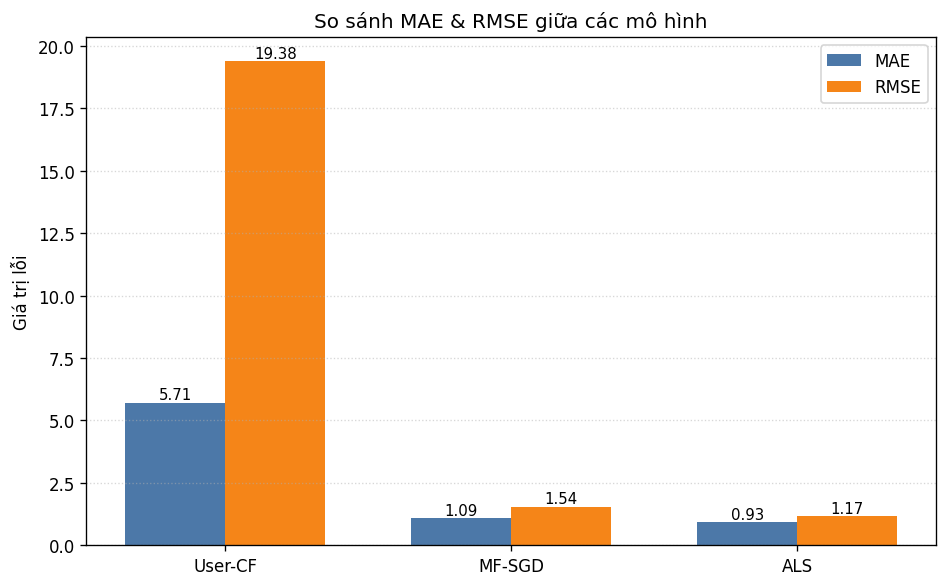

Đã lưu biểu đồ cột tại: ..\figures\bar_metrics.png


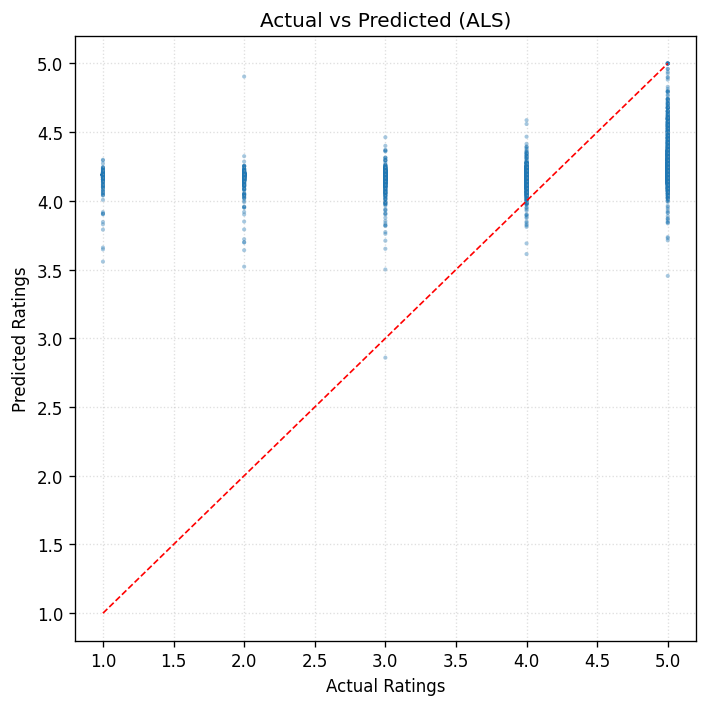

Đã lưu biểu đồ phân tán tại: ..\figures\scatter_actual_vs_pred_best.png


In [15]:
out_dir = os.path.normpath(os.path.join(os.path.dirname("."), "../figures"))
os.makedirs(out_dir, exist_ok=True)

# Lấy số liệu: ưu tiên dùng trung bình 5-Fold (mae_u, rmse_u, ...), nếu chưa có thì dùng test split (mae_user, rmse_user, ...)
def get_metric(name_cv, name_test):
    return globals().get(name_cv, globals().get(name_test))

mae_user_val = get_metric("mae_u", "mae_user")
rmse_user_val = get_metric("rmse_u", "rmse_user")
mae_mf_val   = get_metric("mae_m", "mae_mf")
rmse_mf_val  = get_metric("rmse_m", "rmse_mf")
mae_als_val  = get_metric("mae_a", "mae_als")
rmse_als_val = get_metric("rmse_a", "rmse_als")

models = ["User-CF", "MF-SGD", "ALS"]
mae_vals = [mae_user_val, mae_mf_val, mae_als_val]
rmse_vals = [rmse_user_val, rmse_mf_val, rmse_als_val]

# Biểu đồ cột: MAE & RMSE
x = np.arange(len(models))
w = 0.35
fig, ax = plt.subplots(figsize=(8,5), dpi=120)
ax.bar(x - w/2, mae_vals, width=w, label="MAE", color="#4C78A8")
ax.bar(x + w/2, rmse_vals, width=w, label="RMSE", color="#F58518")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title("So sánh MAE & RMSE giữa các mô hình")
ax.set_ylabel("Giá trị lỗi")
ax.legend()
ax.grid(axis="y", linestyle=":", alpha=0.5)
for i, v in enumerate(mae_vals):
    ax.text(i - w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(rmse_vals):
    ax.text(i + w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
bar_path = os.path.join(out_dir, "bar_metrics.png")
plt.tight_layout()
plt.savefig(bar_path)
plt.show()
print(f"Đã lưu biểu đồ cột tại: {bar_path}")

# Biểu đồ phân tán: Actual vs Predicted của mô hình tốt nhất (trên test split)
best_name = None
best_preds = None
best_rmse = None
candidates = [
    ("User-CF", globals().get("predictions_user_based"), globals().get("rmse_user")),
    ("MF-SGD",  globals().get("predictions_mf"),        globals().get("rmse_mf")),
    ("ALS",     globals().get("predictions_als"),       globals().get("rmse_als")),
]
for name, preds, rmse in candidates:
    if preds is None or rmse is None:
        continue
    if (best_rmse is None) or (rmse < best_rmse):
        best_name, best_preds, best_rmse = name, preds, rmse

if best_preds is not None:
    fig, ax = plt.subplots(figsize=(6,6), dpi=120)
    ax.scatter(y_test, best_preds, s=6, alpha=0.4, edgecolor="none")
    ax.plot([1,5],[1,5], color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("Actual Ratings")
    ax.set_ylabel("Predicted Ratings")
    ax.set_title(f"Actual vs Predicted ({best_name})")
    ax.grid(True, linestyle=":", alpha=0.4)
    scatter_path = os.path.join(out_dir, "scatter_actual_vs_pred_best.png")
    plt.tight_layout()
    plt.savefig(scatter_path)
    plt.show()
    print(f"Đã lưu biểu đồ phân tán tại: {scatter_path}")
else:
    print("Không tìm thấy dự đoán để vẽ scatter. Hãy chạy các ô đánh giá mô hình trước.")
